Create some initial figures for FWE Nexus Belmont looking at projection of climate indices over the South Atlantic Basin.

Aim is to tell a story - when do the extremes happen? How will that affect energy consumption? Food production? water resources etc.

Use the SSP245 results from ARISE-SAI for now - just to see how the figures look.


In [141]:
# Import packages
import numpy as np
import pandas as pd
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from geocat.viz import util as gvutil 
import regionmask

import geoplot as gplt
import geopandas as gpd
import mapclassify as mc


In [4]:
# some files and directories

# Use data calculated for water availability by Ming
prec_indices_8110 = xr.open_dataset('PROGS/PSIF-WaterAvail/Data/CESM2_PrecIndices_HUC2.nc')
prec_indices_4070 = xr.open_dataset('PROGS/PSIF-WaterAvail/Data/CESM2_PrecIndices_HUC2_future.nc')

# directory for SAI/SSP temp indices
inssp = '/glade/work/maritye/Data/ARISE-SAI/ETCCDI/SSP245/'

In [138]:
# extreme indices from Ming's calculations
n95_8110 = xr.open_dataset('PROGS/PSIF-WaterAvail/Data/N95_CESM2_001-010_HUC2_1981-2010.nc')
n95_4070 = xr.open_dataset('PROGS/PSIF-WaterAvail/Data/N95_CESM2_001-010_HUC2_2040-2070.nc')
p95t_8110 = xr.open_dataset('PROGS/PSIF-WaterAvail/Data/P95Tot_CESM2_001-010_HUC2_1981-2010.nc')
p95t_4070 = xr.open_dataset('PROGS/PSIF-WaterAvail/Data/P95Tot_CESM2_001-010_HUC2_2040-2070.nc')

Region of interest for Belmont project is the "Mid Atlantic" or MA, region 2. Happens to be the last region in the array.  
Let's create a set of boxplots that show each index at the MA region 

In [23]:
ireg = 17
MA_8110 = prec_indices_8110.isel(region=ireg)
MA_4070 = prec_indices_4070.isel(region=ireg)

Need to combine the annual and member data into one group to create the bars. Ideally would also have all of the individual grid cells but can do that again if the indices are interesting.

In [56]:
ma8110 = MA_8110.stack(z=('year', 'member'))
ma8110_P = ma8110[['SDII_a', 'CDD', 'CWD']]
ma4070_P = MA_4070.stack(z=('year', 'member'))

varnames = list(MA_4070.keys())

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


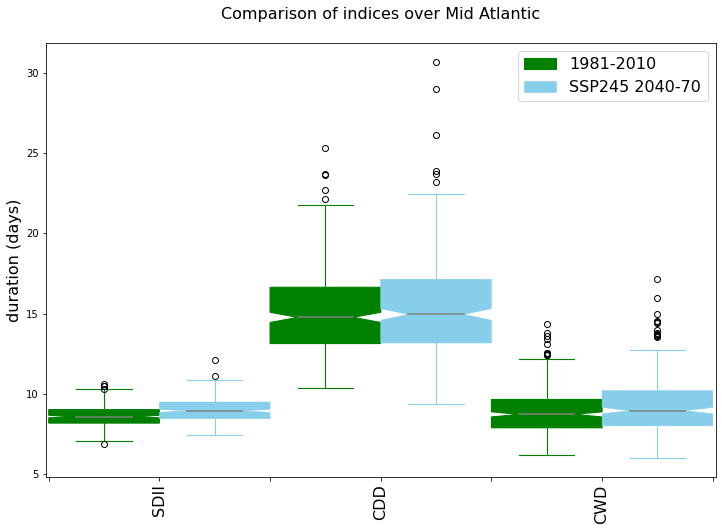

In [137]:
main = 'Comparison of indices over Mid Atlantic'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(
        widths=0.5,  # box width
        showfliers=True, # extreme extents
        patch_artist=True, # colour boxes
        showmeans = False,
        notch=True,
        medianprops={"color": "gray", "linewidth": 1.5},
)

# create a position for each index, current and future scenario
pos1 = np.arange(len(varnames)) - 0.25
pos2 = np.arange(len(varnames)) + 0.25

"""
xposition = np.arange(0,18,2)
for xc in xposition:
        ax.axvline(x=xc, color='whitesmoke', linestyle='-', linewidth=45)
#only want this bit if there are many many indices.
"""
bp1 = ax.boxplot([ma8110_P['SDII_a'], ma8110_P['CDD'], ma8110_P['CWD']],
                         positions=pos1,
                         manage_ticks=False,
                              boxprops={"facecolor": "green", "edgecolor": "green",
                                  "linewidth": 1.1},
                             whiskerprops={"color": "green", "linewidth": 1.1},
                            capprops={"color": "green", "linewidth": 1.1}, 
                           **kwargs,
                           )

bp2 = ax.boxplot([ma4070_P['SDII'], ma4070_P['CDD'], ma4070_P['CWD']],
                         positions=pos2,
                         boxprops={"facecolor": "skyblue", "edgecolor": "skyblue",
                                  "linewidth": 0.5},
                                whiskerprops={"color": "skyblue", "linewidth": 1.1},
                                capprops={"color": "skyblue", "linewidth": 1.1},
                        manage_ticks=False,
                           **kwargs,
                           )


# format axes
ax.set_xticklabels(["", "", 'SDII', "",'CDD',"",'CWD'], rotation=90, fontsize=16)



# Use geocat.viz.util convenience function to add title to the plot axis.
gvutil.set_titles_and_labels(ax,
                                     maintitle= main,
                                     maintitlefontsize=16,
                             ylabel='duration (days)'
                            )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["1981-2010", "SSP245 2040-70"], fontsize=16)



        # Display Plot
plt.savefig('FWE_resilience_Pdex_indices.png')
plt.show()
plt.close()

Now read in the indices calculated for ARISE-SAI-1.5. Just to show what might be included and see if there's anything interesting to say.

In [139]:
saiIn = '/glade/work/maritye/Data/ARISE-SAI/ETCCDI/SSP245/'

Need to use a shapefile to create the regions and identify lat lon coordinates to trim the global data down.

In [143]:
# open shapefile to use as an aoi

flnm_shp = '/glade/work/mingge/SHAPEFILES/usgs_hucs/HUC02_conus.shp'
huc2_gdf = gpd.read_file(flnm_shp)


In [153]:
# helper function from earthdatascience.org to extract info from AOI

def get_aoi(shp, world=True):
    """ Takes a geopandas object and converts it to lat/lon extent"""
    
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]
    
    # Handle the 0-360 lon values
    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
        
    lon_lat['lon'] = aoi_lon
    lon_lat['lat'] = aoi_lat
    return lon_lat

In [169]:
midatl_rg = huc2_gdf[huc2_gdf.str_id.isin(['MA'])]
midatl_aoi = get_aoi(midatl_rg)

In [269]:
# start with precipitation indices. 

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001-010.PRECTOT_Rx1_Rx5_R1_R10_R20_SDII.2015-2070.nc') as pdex:
    pdex_huc2 = pdex.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))
    
with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.CDD.2015-2069.nc') as cdd:
    cdd_huc2 = cdd.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.CWD.2015-2069.nc') as cwd:
    cwd_huc2 = cwd.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.TNN.2015-2070.nc') as tnn:
    tnn_huc2 = tnn.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.TNX.2015-2070.nc') as tnx:
    tnx_huc2 = tnx.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.TXN.2015-2070.nc') as txn:
    txn_huc2 = txn.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.TXX.2015-2070.nc') as txx:
    txx_huc2 = txx.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.TN90.2015-2070.nc') as tn90:
    tn90_huc2 = tn90.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.TX90.2015-2070.nc') as tx90:
    tx90_huc2 = tx90.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.SU.2015-2070.nc') as su:
    su_huc2 = su.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))

with xr.open_dataset(saiIn + 'b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.cam.h1.FD.2015-2070.nc') as fd:
    fd_huc2 = fd.sel(lon=slice(midatl_aoi['lon'][0], midatl_aoi['lon'][1])).sel(lat=slice(midatl_aoi['lat'][0], midatl_aoi['lat'][1]))


In [181]:
# create geopandas regionmask
huc_mask = regionmask.mask_3D_geopandas(midatl_rg,
                                          fd_huc2.lon,
                                          fd_huc2.lat)


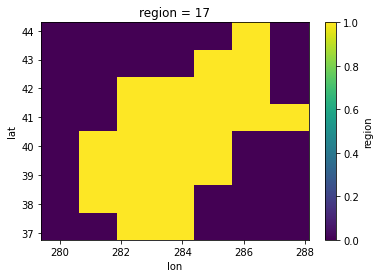

In [182]:
huc_mask.plot();

In [270]:
# Current period data
pdex_cp = pdex_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
cdd_cp = cdd_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
cwd_cp = cwd_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
tnn_cp = tnn_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
tnx_cp = tnx_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
txn_cp = txn_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
txx_cp = txx_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
tn90_cp = tn90_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
tx90_cp = tx90_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
su_cp = su_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()
fd_cp = fd_huc2.where(huc_mask).sel(year=slice(2015,2025)).squeeze()

In [271]:
# Future period data
pdex_fp = pdex_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
cdd_fp = cdd_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
cwd_fp = cwd_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
tnn_fp = tnn_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
tnx_fp = tnx_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
txn_fp = txn_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
txx_fp = txx_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
tn90_fp = tn90_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
tx90_fp = tx90_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
su_fp = su_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()
fd_fp = fd_huc2.where(huc_mask).sel(year=slice(2050,2070)).squeeze()

In [272]:
# To account for the spatial variability in values (and short time series) stack data by ensemble member, lat and lon, and take the mean over the year, and drop na values
pdex_cp_stax = pdex_cp.mean('year').stack(z=('ens', 'lat', 'lon')).dropna('z')
cdd_cp_stax = cdd_cp.mean('year').stack(z=('member', 'lat', 'lon')).dropna('z')
cwd_cp_stax = cwd_cp.mean('year').stack(z=('member', 'lat', 'lon')).dropna('z')
tnn_cp_stax = tnn_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
tnx_cp_stax = tnx_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
txn_cp_stax = txn_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
txx_cp_stax = txx_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
tn90_cp_stax = tn90_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
tx90_cp_stax = tx90_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
su_cp_stax = su_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
fd_cp_stax = fd_cp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')


In [273]:
# To account for the spatial variability in values (and short time series) stack data by ensemble member, lat and lon, and take the mean over the year, and drop na values
pdex_fp_stax = pdex_fp.mean('year').stack(z=('ens', 'lat', 'lon')).dropna('z')
cdd_fp_stax = cdd_fp.mean('year').stack(z=('member', 'lat', 'lon')).dropna('z')
cwd_fp_stax = cwd_fp.mean('year').stack(z=('member', 'lat', 'lon')).dropna('z')
tnn_fp_stax = tnn_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
tnx_fp_stax = tnx_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
txn_fp_stax = txn_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
txx_fp_stax = txx_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
tn90_fp_stax = tn90_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
tx90_fp_stax = tx90_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
su_fp_stax = su_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')
fd_fp_stax = fd_fp.mean('year').stack(z=('members', 'lat', 'lon')).dropna('z')


/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


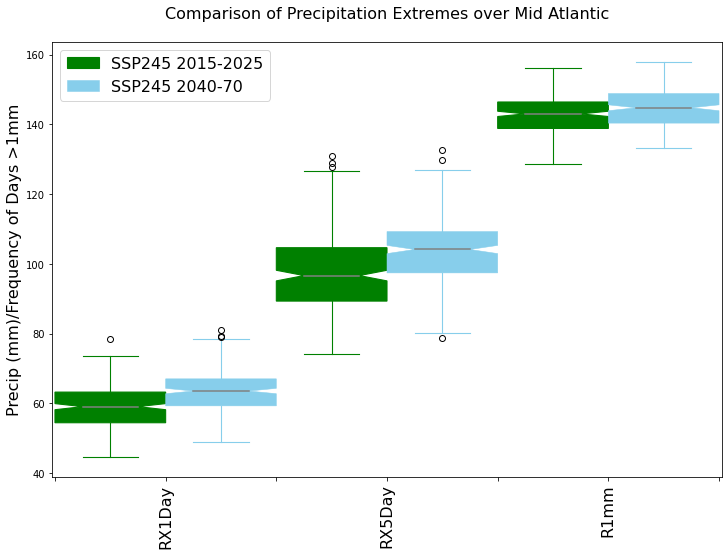

In [264]:
main = 'Comparison of Precipitation Extremes over Mid Atlantic'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(
        widths=0.5,  # box width
        showfliers=True, # extreme extents
        patch_artist=True, # colour boxes
        showmeans = False,
        notch=True,
        medianprops={"color": "gray", "linewidth": 1.5},
)

# create a position for each index, current and future scenario
pos1 = np.arange(len(varnames)) - 0.25
pos2 = np.arange(len(varnames)) + 0.25

"""
xposition = np.arange(0,18,2)
for xc in xposition:
        ax.axvline(x=xc, color='whitesmoke', linestyle='-', linewidth=45)
#only want this bit if there are many many indices.
"""
bp1 = ax.boxplot([pdex_cp_stax['RX1D'], pdex_cp_stax['RX5D'], pdex_cp_stax['R1mm']],
                         positions=pos1,
                         manage_ticks=False,
                              boxprops={"facecolor": "green", "edgecolor": "green",
                                  "linewidth": 1.1},
                             whiskerprops={"color": "green", "linewidth": 1.1},
                            capprops={"color": "green", "linewidth": 1.1}, 
                           **kwargs,
                           )

bp2 = ax.boxplot([pdex_fp_stax['RX1D'], pdex_fp_stax['RX5D'], pdex_fp_stax['R1mm']],
                         positions=pos2,
                         boxprops={"facecolor": "skyblue", "edgecolor": "skyblue",
                                  "linewidth": 0.5},
                                whiskerprops={"color": "skyblue", "linewidth": 1.1},
                                capprops={"color": "skyblue", "linewidth": 1.1},
                        manage_ticks=False,
                           **kwargs,
                           )


# format axes
ax.set_xticklabels(["", "", 'RX1Day', "",'RX5Day',"",'R1mm'], rotation=90, fontsize=16)



# Use geocat.viz.util convenience function to add title to the plot axis.
gvutil.set_titles_and_labels(ax,
                                     maintitle= main,
                                     maintitlefontsize=16,
                             ylabel='Precip (mm)/Frequency of Days >1mm'
                            )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["SSP245 2015-2025", "SSP245 2040-70"], fontsize=16)



        # Display Plot
plt.savefig('FWE_resilience_Rx1RX5_indices.png')
plt.show()
plt.close()

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


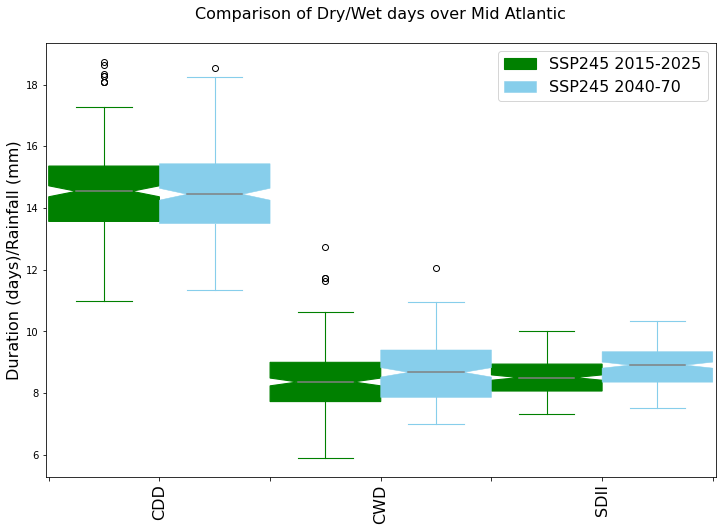

In [265]:
main = 'Comparison of Dry/Wet days over Mid Atlantic'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(
        widths=0.5,  # box width
        showfliers=True, # extreme extents
        patch_artist=True, # colour boxes
        showmeans = False,
        notch=True,
        medianprops={"color": "gray", "linewidth": 1.5},
)

# create a position for each index, current and future scenario
pos1 = np.arange(len(varnames)) - 0.25
pos2 = np.arange(len(varnames)) + 0.25

"""
xposition = np.arange(0,18,2)
for xc in xposition:
        ax.axvline(x=xc, color='whitesmoke', linestyle='-', linewidth=45)
#only want this bit if there are many many indices.
"""
bp1 = ax.boxplot([cdd_cp_stax['CDD'], cwd_cp_stax['CWD'], pdex_cp_stax['SDII']],
                         positions=pos1,
                         manage_ticks=False,
                              boxprops={"facecolor": "green", "edgecolor": "green",
                                  "linewidth": 1.1},
                             whiskerprops={"color": "green", "linewidth": 1.1},
                            capprops={"color": "green", "linewidth": 1.1}, 
                           **kwargs,
                           )

bp2 = ax.boxplot([cdd_fp_stax['CDD'], cwd_fp_stax['CWD'], pdex_fp_stax['SDII']],
                         positions=pos2,
                         boxprops={"facecolor": "skyblue", "edgecolor": "skyblue",
                                  "linewidth": 0.5},
                                whiskerprops={"color": "skyblue", "linewidth": 1.1},
                                capprops={"color": "skyblue", "linewidth": 1.1},
                        manage_ticks=False,
                           **kwargs,
                           )


# format axes
ax.set_xticklabels(["", "", 'CDD', "",'CWD',"",'SDII'], rotation=90, fontsize=16)



# Use geocat.viz.util convenience function to add title to the plot axis.
gvutil.set_titles_and_labels(ax,
                                     maintitle= main,
                                     maintitlefontsize=16,
                             ylabel='Duration (days)/Rainfall (mm)'
                            )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["SSP245 2015-2025", "SSP245 2040-70"], fontsize=16)



        # Display Plot
plt.savefig('FWE_resilience_drought_indices.png')
plt.show()
plt.close()

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


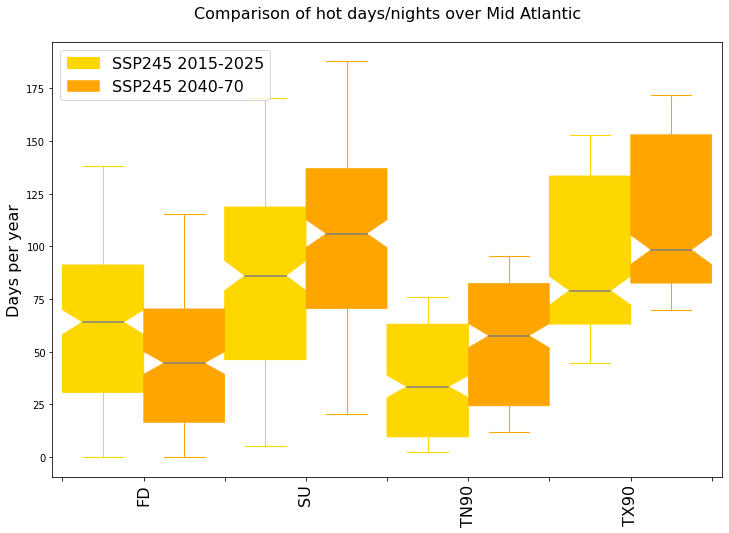

In [263]:
main = 'Comparison of hot days/nights over Mid Atlantic'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(
        widths=0.5,  # box width
        showfliers=True, # extreme extents
        patch_artist=True, # colour boxes
        showmeans = False,
        notch=True,
        medianprops={"color": "gray", "linewidth": 1.5},
)

# create a position for each index, current and future scenario
pos1 = np.arange(4) - 0.25
pos2 = np.arange(4) + 0.25

bp1 = ax.boxplot([fd_cp_stax['FD'], su_cp_stax['SU'], tn90_cp_stax['TN90'], tx90_cp_stax['TX90']],
                         positions=pos1,
                         manage_ticks=False,
                              boxprops={"facecolor": "gold", "edgecolor": "gold",
                                  "linewidth": 1.1},
                             whiskerprops={"color": "gold", "linewidth": 1.1},
                            capprops={"color": "gold", "linewidth": 1.1}, 
                           **kwargs,
                           )

bp2 = ax.boxplot([fd_fp_stax['FD'], su_fp_stax['SU'], tn90_fp_stax['TN90'], tx90_fp_stax['TX90']],
                         positions=pos2,
                         boxprops={"facecolor": "orange", "edgecolor": "orange",
                                  "linewidth": 0.5},
                                whiskerprops={"color": "orange", "linewidth": 1.1},
                                capprops={"color": "orange", "linewidth": 1.1},
                        manage_ticks=False,
                           **kwargs,
                           )


# format axes
ax.set_xticklabels(["", "", 'FD', "",'SU',"",'TN90', '', 'TX90'], rotation=90, fontsize=16)



# Use geocat.viz.util convenience function to add title to the plot axis.
gvutil.set_titles_and_labels(ax,
                                     maintitle= main,
                                     maintitlefontsize=16,
                             ylabel='Days per year'
                            )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["SSP245 2015-2025", "SSP245 2040-70"], fontsize=16)



        # Display Plot
plt.savefig('FWE_resilience_heat_indices.png')
plt.show()
plt.close()

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


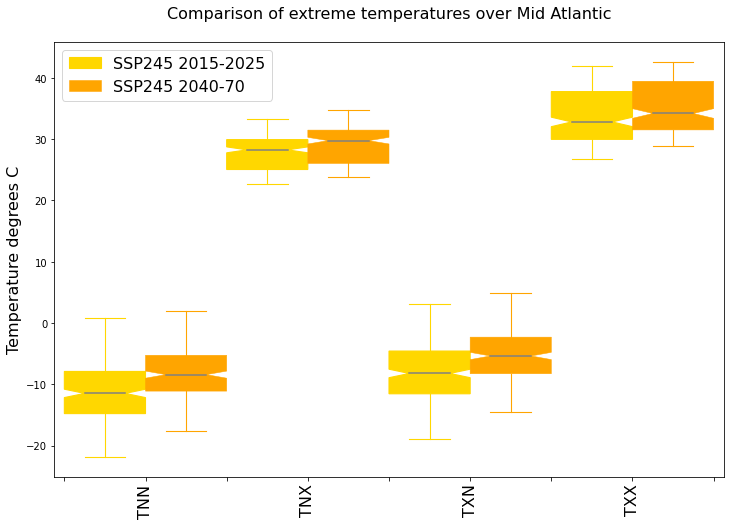

In [274]:
main = 'Comparison of extreme temperatures over Mid Atlantic'
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
kwargs = dict(
        widths=0.5,  # box width
        showfliers=True, # extreme extents
        patch_artist=True, # colour boxes
        showmeans = False,
        notch=True,
        medianprops={"color": "gray", "linewidth": 1.5},
)

# create a position for each index, current and future scenario
pos1 = np.arange(4) - 0.25
pos2 = np.arange(4) + 0.25

bp1 = ax.boxplot([tnn_cp_stax['TNN'], tnx_cp_stax['TNX'], txn_cp_stax['TXN'], txx_cp_stax['TXX']],
                         positions=pos1,
                         manage_ticks=False,
                              boxprops={"facecolor": "gold", "edgecolor": "gold",
                                  "linewidth": 1.1},
                             whiskerprops={"color": "gold", "linewidth": 1.1},
                            capprops={"color": "gold", "linewidth": 1.1}, 
                           **kwargs,
                           )

bp2 = ax.boxplot([tnn_fp_stax['TNN'], tnx_fp_stax['TNX'], txn_fp_stax['TXN'], txx_fp_stax['TXX']],
                         positions=pos2,
                         boxprops={"facecolor": "orange", "edgecolor": "orange",
                                  "linewidth": 0.5},
                                whiskerprops={"color": "orange", "linewidth": 1.1},
                                capprops={"color": "orange", "linewidth": 1.1},
                        manage_ticks=False,
                           **kwargs,
                           )


# format axes
ax.set_xticklabels(["", "", 'TNN', "",'TNX',"",'TXN', '', 'TXX'], rotation=90, fontsize=16)



# Use geocat.viz.util convenience function to add title to the plot axis.
gvutil.set_titles_and_labels(ax,
                                     maintitle= main,
                                     maintitlefontsize=16,
                             ylabel='Temperature degrees C'
                            )

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["SSP245 2015-2025", "SSP245 2040-70"], fontsize=16)



        # Display Plot
plt.savefig('FWE_resilience_TX_TN_indices.png')
plt.show()
plt.close()

Finally, take a look at the LOCA downscaled data. Does this show anything different? I suspect not really for temperatures